# Summary:
This is the 3rd of 3 notebooks.

1. A Logistic Regression Model and an LGBM model are developed\
    a. Model development data (data from exercise 40 train) is randomly split into train/validation of 75%/25%\
    b. Model is developed on the train data and its performance is evaluated on both the train and validation data\
    c. K-fold cross validation and Hyperparameter tuning is used to avoid overfitting\
    d. Variance inflation factor is computed on all the predictors to check for collinearity in the model
2. Model performance metric: AUC-ROC and KS are used to evaluate both model performance on the the training and validation data
3. Upon confirming the models's stability, the are scored on the test data (data from exercise 40 test) and the probabilities of 1 are exported into glmresults.csv and nonglmresults.csv

# 1. Import Libraries

In [ ]:
# !pip install shap bayesian-optimization openpyxl

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import re #regular expression

import matplotlib.pyplot as plt #For plotting graphs
import matplotlib.ticker as mtick

#include plots in the notebook
%matplotlib inline 
import seaborn as sns #For plotting graphs
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder #for creating dummy variables out of categorical variables
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, \
confusion_matrix, mean_squared_error, balanced_accuracy_score,roc_curve,auc
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from scipy.stats import chi2_contingency

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Recursive Feature Elimination
from probatus.feature_elimination import ShapRFECV

#utilities
import collections

import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

import joblib

from functions import plot_auc1, plot_auc2, performance_metrics

# 1. Read data

In [ ]:
df_train_woe = pd.read_csv('df_train_woe.csv')
df_test_woe = pd.read_csv('df_test_woe.csv')

In [ ]:
# Read top variables
list_lr = pd.read_pickle('list_lr.pkl')

In [ ]:
df_train1 = df_train_woe.copy()
df_train1 = df_train1[list_lr+['y']]
df_test1 = df_train_woe.copy()
df_test1 = df_test_woe[list_lr]

### Train/val Split

In [ ]:
y = df_train1.y
X = df_train1.drop(columns='y')

In [ ]:
# Divide the data into training and testing datasets
# stratified sampling: same percentage from each class

X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y, test_size=.25, random_state=42)
X_train.shape, X_val.shape

((30000, 16), (10000, 16))

In [ ]:
# Create train and validation datasets to include the target variable
df_train2 = pd.merge(X_train,y_train,left_index=True,right_index=True)
df_val2 = pd.merge(X_val,y_val,left_index=True,right_index=True)

# Develop logistic regression model

In [ ]:
#Instatiate Logistic Regression Classifier
clf_lr = LogisticRegression(random_state=42)

# define grid search
grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'penalty': ['l2'],
         'C': [100, 10, 1.0, 0.1, 0.01]}

grid_search = HalvingGridSearchCV(estimator=clf_lr, param_grid=grid, n_jobs=-1, cv=5, \
                                  scoring='roc_auc',error_score=0,random_state=42)
grid_search.fit(X, y)
# grid_result = grid_search.fit(X, y)

best_clf = grid_search.best_estimator_
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

df_train2['y_pred'] = best_clf.predict_proba(df_train2[list_lr])[:,1]
df_val2['y_pred'] = best_clf.predict_proba(df_val2[list_lr])[:,1]

Best: 0.811448 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


### Validate predictions

In [ ]:
print('Train Actual : ', df_train2['y'].sum(),', Train Predicted : ',df_train2['y_pred'].sum())
print('Val Actual : ', df_val2['y'].sum(),', Val Predicted : ',df_val2['y_pred'].sum())

Train Actual :  4352 , Train Predicted :  4352.042963146136
Val Actual :  1451 , Val Predicted :  1450.9570368730947


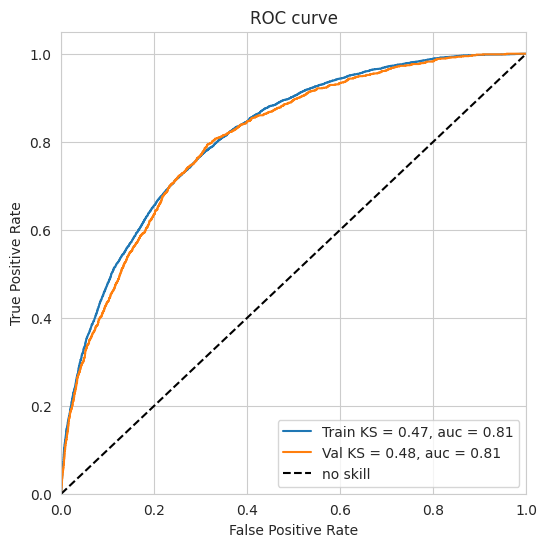

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
plot_auc2(ax, y_train, df_train2['y_pred'], y_val, df_val2['y_pred'])

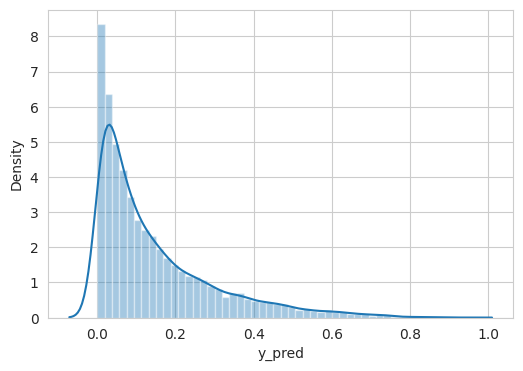

<Figure size 640x480 with 0 Axes>

In [ ]:
# Distribution of predicted probabilities on validation data
f, ax = plt.subplots(figsize=(6,4))
sns.distplot(df_val2['y_pred'])
fig = plt.figure()

1. The AUC ROC curves for train and test are almost on top of each other indicating that the model is stable. 
2. Both train and test AUC are 81%. 
3. The KS are also high and close to 47% 

### Variables contribution using Shap

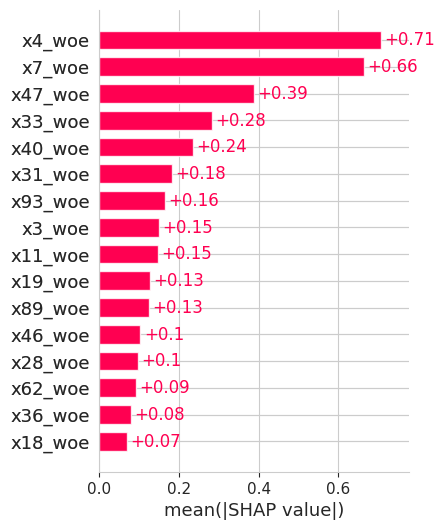

In [ ]:
explainer = shap.Explainer(best_clf, X_train, feature_names=[list_lr])
shap_values = explainer(X_val)
fig = plt.figure()
shap.plots.bar(shap_values, max_display=20,show = False)
plt.gcf().set_size_inches(4,6)
plt.show()

### Variance inflation factor

In [ ]:
# importing the variance_inflation_factor() function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# extracting the numerical columns

# VIF dataframe
vif_data = pd.DataFrame()
vif_data['Feature'] = df_val2[list_lr].columns
  
# calculating VIF for each feature
vif_data['VIF_Train']= [variance_inflation_factor(df_train2[list_lr].values, i) for i in range(len(df_train2[list_lr].columns))]
vif_data['VIF_Val']= [variance_inflation_factor(df_val2[list_lr].values, i) for i in range(len(df_val2[list_lr].columns))]

# printing the VIF of each feature
print(vif_data)

    Feature  VIF_Train   VIF_Val
0   x36_woe   2.335741  2.358826
1   x18_woe   1.914676  1.947361
2   x31_woe   1.387643  1.391019
3   x40_woe   1.632502  1.604741
4   x11_woe   1.333415  1.310310
5   x93_woe   1.389347  1.390797
6   x47_woe   3.003577  2.969348
7    x7_woe   1.013116  1.013127
8   x89_woe   1.391788  1.389979
9   x46_woe   1.136702  1.141653
10   x3_woe   1.000813  1.001923
11  x19_woe   1.001224  1.002487
12  x28_woe   3.657620  3.714506
13  x62_woe   1.237551  1.233270
14  x33_woe   1.002805  1.002409
15   x4_woe   1.012968  1.012501


All the VIFs between of the variables are small

### Score exercise_40_test data

In [ ]:
df_test_woe['y_pred'] = grid_search.predict_proba(df_test_woe[list_lr])[:,1]

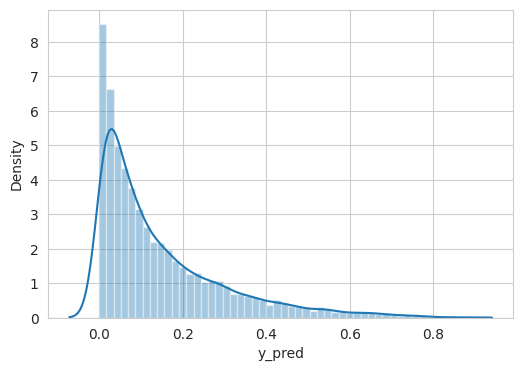

<Figure size 640x480 with 0 Axes>

In [ ]:
# The distribution of predicted probabilities on the test looks similar to that on the validation data
f, ax = plt.subplots(figsize=(6,4))
sns.distplot(df_test_woe['y_pred'])
fig = plt.figure()

In [ ]:
df_test_woe['y_pred'].to_csv('glmresults.csv',index=False)

### Save model

In [ ]:
# save model to file
joblib.dump(grid_search, 'LogisticRegressionModel.pkl')

['LogisticRegressionModel.pkl']

In [ ]:
# load the model from disk
loaded_model = joblib.load('LogisticRegressionModel.pkl')

data1 = df_train2.copy()
data2 = df_val2.copy()

data1['y_pred1'] = grid_search.predict_proba(data1[list_lr])[:,1]
data2['y_pred1'] = grid_search.predict_proba(data2[list_lr])[:,1]

print(data1['y_pred'].sum(),data1['y_pred1'].sum())
print(data2['y_pred'].sum(),data2['y_pred1'].sum())

4352.042963146136 4352.042963146136
1450.9570368730947 1450.9570368730947


# Develop LGBM model

In [ ]:
lgb=LGBMClassifier()

grid = {'num_leaves':[20,40,60,80,100], 
              'min_child_samples':[5,10,15],
              'max_depth':[5,10,20],
             'learning_rate':[0.05,0.1,0.2],
       }

grid_search = HalvingGridSearchCV(estimator=lgb, param_grid=grid, n_jobs=-1, cv=5, \
                                  scoring='roc_auc',random_state=42)

grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

df_train2['y_pred'] = grid_search.predict_proba(df_train2[list_lr])[:,1]
df_val2['y_pred'] = grid_search.predict_proba(df_val2[list_lr])[:,1]

Best: 0.803761 using {'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 15, 'num_leaves': 20}


### Validate predictions

In [ ]:
print('Train Actual : ', df_train2['y'].sum(),', Train Predicted : ',df_train2['y_pred'].sum())
print('Val Actual : ', df_val2['y'].sum(),', Val Predicted : ',df_val2['y_pred'].sum())

Train Actual :  4352 , Train Predicted :  4354.891774278163
Val Actual :  1451 , Val Predicted :  1451.7801903233715


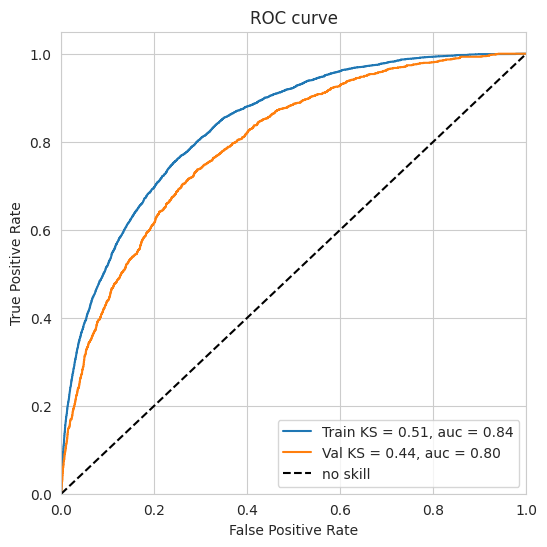

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
plot_auc2(ax, y_train, df_train2['y_pred'], y_val, df_val2['y_pred'])

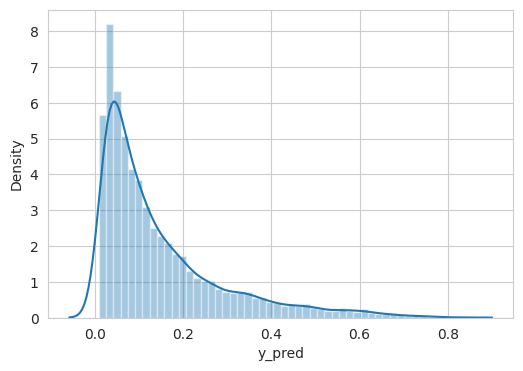

<Figure size 640x480 with 0 Axes>

In [ ]:
# Distribution of predicted probabilities on validation data
f, ax = plt.subplots(figsize=(6,4))
sns.distplot(df_val2['y_pred'])
fig = plt.figure()

### Variable contribution using Shap

 99%|===================| 9944/10000 [00:51<00:00]        

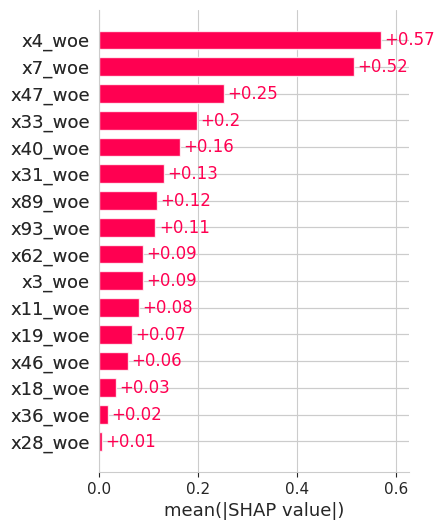

In [ ]:
explainer = shap.Explainer(best_clf, X_train, feature_names=[list_lr])
shap_values = explainer(X_val)
fig = plt.figure()
shap.plots.bar(shap_values, max_display=20,show = False)
plt.gcf().set_size_inches(4,6)
plt.show()

### Score exercise_40_test data

In [ ]:
df_test_woe['y_pred'] = best_clf.predict_proba(df_test_woe[list_lr])[:,1]

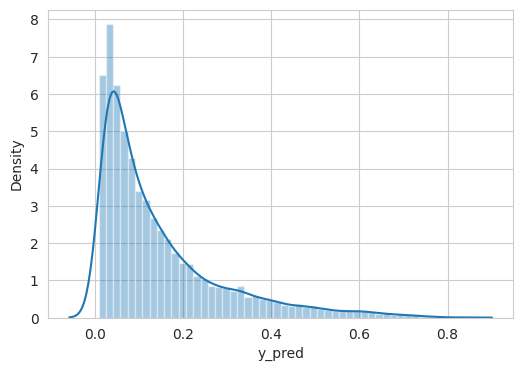

<Figure size 640x480 with 0 Axes>

In [ ]:
# The distribution of predicted probabilities on the test looks similar to that on the validation data
f, ax = plt.subplots(figsize=(6,4))
sns.distplot(df_test_woe['y_pred'])
fig = plt.figure()

In [ ]:
df_test_woe['y_pred'].to_csv('nonglmresults.csv',index=False)

### Save model

In [ ]:
# save model to file
joblib.dump(best_clf, 'LGBMModel.pkl')

['LGBMModel.pkl']

In [ ]:
# load the model from disk
loaded_model = joblib.load('LGBMModel.pkl')

data1 = df_train2.copy()
data2 = df_val2.copy()

data1['y_pred1'] = grid_search.predict_proba(data1[list_lr])[:,1]
data2['y_pred1'] = grid_search.predict_proba(data2[list_lr])[:,1]

print(data1['y_pred'].sum(),data1['y_pred1'].sum())
print(data2['y_pred'].sum(),data2['y_pred1'].sum())

4354.891774278163 4354.891774278163
1451.7801903233715 1451.7801903233715
